cuda

Wave Power:9.389143815496936e-05
Radar Power:0.00010001000191550702


100%|██████████| 1000/1000 [00:01<00:00, 674.33it/s]


LFM (with abs)==========
Mean value->355.5490417480469, 	 Variance->5.444566249847412
Mean value->2.3703271381236846e-06, 	 Variance->2.4198098117653936e-16 	 CRLB:2.374952535065582e-16
MSE: 5.642483711242676


100%|██████████| 1000/1000 [00:01<00:00, 577.80it/s]


LFM (with real)==========
Mean value->355.54302978515625, 	 Variance->1.488958716392517
Mean value->2.370287347730482e-06, 	 Variance->6.617599086890401e-17 	 CRLB:5.937381337663955e-17
MSE: 1.696277141571045


100%|██████████| 1000/1000 [00:01<00:00, 546.38it/s]


Wave==========
Mean value->355.5265197753906, 	 Variance->0.22969122231006622
Mean value->2.3701772988715675e-06, 	 Variance->1.0208505600396607e-17
MSE: 0.4536157548427582
tensor(6.1006e-07, device='cuda:0')
tensor(5.4005e-07, device='cuda:0')


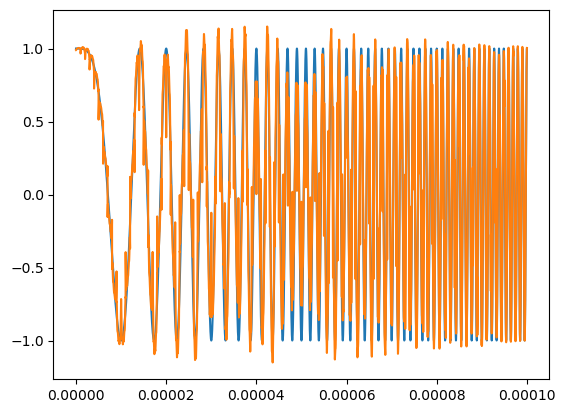

<Figure size 640x480 with 0 Axes>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

t = torch.linspace(0, 1e-4, int(1e4), device=device)
dt = t[1] - t[0]

# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval
A = 0.8
MN = 1000
distance = 356
N0 = 10
comm_pulse_kind = 'OFDMA'
radar_pulse_kind = 'LFM'

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)
g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
radar_pulse = myRadarPulses.LFM_pulse(B)

g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)

Q = torch.matmul(g_vec, g_vec.conj().T)*(t[1]-t[0])
R = radar_pulse.repeat(K*L, 1)
G = torch.diag(torch.matmul(R, g_vec.conj().T))*(t[1]-t[0])
c_opt = torch.matmul(G, torch.inverse(Q))
s_opt = torch.sum(c_opt[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)

plt.figure()
plt.plot(t.cpu(), radar_pulse.cpu().real)
plt.plot(t.cpu(), s_opt.cpu().real)

print()
print(f"Wave Power:{torch.sum(torch.abs(s_opt)**2)*dt}")
print(f"Radar Power:{torch.sum(torch.abs(radar_pulse)**2)*dt}")

dis, ta = myRadarPulses.montecarlo_estimation_with_abs(radar_pulse, N0, distance, np.sqrt(A), 3e8, MN)
print("LFM (with abs)" + "="*10)
print(f'Mean value->{torch.mean(dis)}, \t Variance->{torch.var(dis)}')
print(f'Mean value->{torch.mean(ta)}, \t Variance->{torch.var(ta)} \t CRLB:{myRadarPulses.LFM_delayCRLB_with_abs(B, T, N0, A)}')
print(f"MSE: {torch.mean(torch.abs(dis - distance)**2)}")

dis, ta = myRadarPulses.montecarlo_estimation_with_real(radar_pulse, N0, distance, np.sqrt(A), 3e8, MN)
print("LFM (with real)" + "="*10)
print(f'Mean value->{torch.mean(dis)}, \t Variance->{torch.var(dis)}')
print(f'Mean value->{torch.mean(ta)}, \t Variance->{torch.var(ta)} \t CRLB:{myRadarPulses.LFM_delayCRLB_with_real(B, T, N0, A)}')
print(f"MSE: {torch.mean(torch.abs(dis - distance)**2)}")

dis, ta = myRadarPulses.montecarlo_estimation_with_real(s_opt, N0, distance, np.sqrt(A), 3e8, MN)
print("Wave" + "="*10)
print(f'Mean value->{torch.mean(dis)}, \t Variance->{torch.var(dis)}')
print(f'Mean value->{torch.mean(ta)}, \t Variance->{torch.var(ta)}')
print(f"MSE: {torch.mean(torch.abs(dis - distance)**2)}")

plt.figure()
xcr_LFM = torch.abs(myRadarPulses.cross_correlation(radar_pulse, radar_pulse))
xcr_mySig = torch.abs(myRadarPulses.cross_correlation(s_opt, s_opt))

print(torch.argmin(torch.abs(xcr_LFM - xcr_LFM[torch.argmax(xcr_LFM)]/2)**2)*dt)
print(torch.argmin(torch.abs(xcr_mySig - xcr_mySig[torch.argmax(xcr_mySig)]/2)**2)*dt)
# print(xcr_LFM[torch.argmax(xcr_LFM)])
# print(xcr_mySig[torch.argmax(xcr_mySig)])

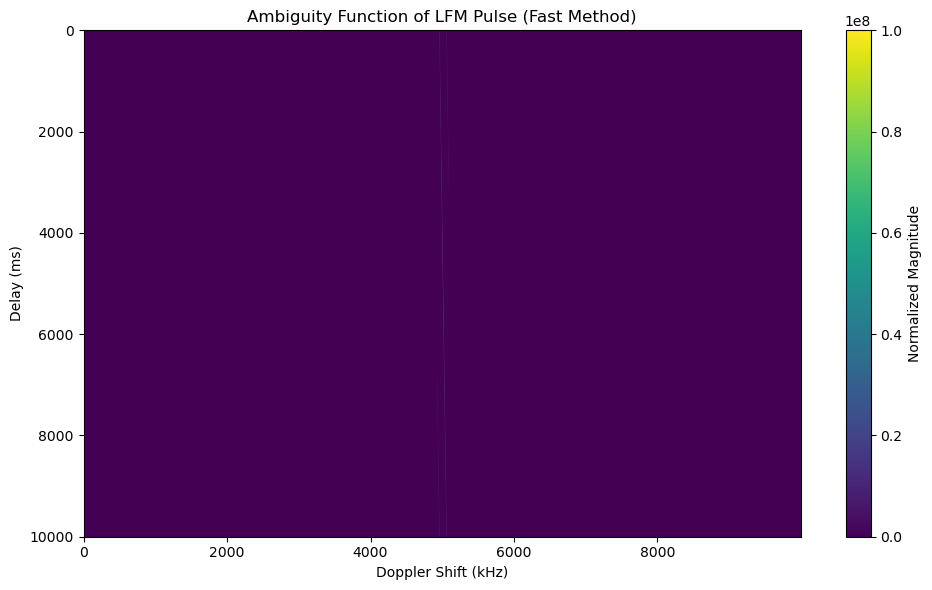

IndexError: index 50005000 is out of bounds for dimension 0 with size 10001

In [10]:
ambiguity = myRadarPulses.fast_ambiguity(radar_pulse, radar_pulse)

# Magnitude squared (normalized)
ambiguity_mag = torch.abs(ambiguity)**2
# ambiguity_mag = ambiguity_mag / torch.max(ambiguity_mag)

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(ambiguity_mag.cpu().numpy(),
           aspect='auto', cmap='viridis')
plt.xlabel('Doppler Shift (kHz)')
plt.ylabel('Delay (ms)')
plt.title('Ambiguity Function of LFM Pulse (Fast Method)')
plt.colorbar(label='Normalized Magnitude')
plt.tight_layout()
plt.show()

ambiguity_mag[torch.argmax(ambiguity_mag)]